# Model and final preprocessing
This notebook is doing the heavy lifting before the visualization. It builds, trains, and runs a ML model, and processes the data to a dataframe my visualization can work with.

## Steps:
* Read dataset from part 2, does some preprocessing for machine learning.
* It then trains a Random Forrest, trying to predict bodyweight
* Appends a prediction to the final dataset
* Removes columns not needed/used in visualization

## Setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
import pydot

from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option("display.max_columns", 101)

### Read in data from last assignment

In [3]:
OUTPUT_FOLDER = 'output'
OUTPUT_DATASET = OUTPUT_FOLDER + '/' + 'consolidated_dataset.csv'

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

consolidated_dataset = pd.read_csv(OUTPUT_DATASET, index_col=0, parse_dates=['Date'])#, date_parser=dateparse)
df = consolidated_dataset

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (40,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df = consolidated_dataset.copy()#head(10000).copy()

In [5]:
df

,Name,Continent,Country,Sex,Age,BodyweightKg,Valid_Results,Competition_year,Date,Event,Equipment,WeightClassKg,AgeClass,Division,Tested,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Wilks_Old,Wilks_2020,Mean height,Mean height lower 95% uncertainty interval,Mean height upper 95% uncertainty interval,Mean height standard error,State,Federation,ParentFederation,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,Europe,Russia,F,33.0,58.30,True,2019,2019-05-11,SBD,Raw,60,24-34,O,Yes,75.0,80.0,-90.0,80.0,50.0,55.0,60.0,60.0,95.0,105.0,107.5,107.5,247.5,1,279.44,282.18,249.42,57.10,104.412659,104.412659,164.396953,163.619191,165.201879,0.403077,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,Europe,Russia,F,43.0,73.10,True,2019,2019-05-11,SBD,Raw,75,40-44,M1,Yes,95.0,100.0,105.0,105.0,62.5,67.5,-72.5,67.5,100.0,110.0,-120.0,110.0,282.5,1,278.95,272.99,240.35,56.76,58.012415,58.012415,164.014897,163.492915,164.532035,0.267605,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,Europe,Russia,M,15.5,67.40,True,2019,2019-05-11,SBD,Raw,75,16-17,T,Yes,85.0,90.0,100.0,100.0,55.0,62.5,-65.0,62.5,90.0,100.0,105.0,105.0,267.5,1,206.40,206.49,200.45,41.24,244.997025,244.997025,171.738549,169.903403,173.548792,0.924952,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,Europe,Russia,M,35.0,66.65,True,2019,2019-05-11,SBD,Raw,75,35-39,O,Yes,125.0,132.0,137.5,137.5,115.0,122.5,-127.5,122.5,150.0,165.0,170.0,170.0,430.0,1,334.49,334.94,325.32,66.68,396.936740,396.936740,176.819650,175.867796,177.757207,0.472990,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,Europe,Russia,M,26.5,72.45,True,2019,2019-05-11,SBD,Raw,75,24-34,O,Yes,80.0,85.0,90.0,90.0,40.0,50.0,-60.0,50.0,112.5,120.0,125.0,125.0,265.0,1,194.46,193.55,187.29,39.34,231.063262,231.063262,176.191941,174.683642,177.673411,0.762665,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153641,Inna Orobets,Europe,Ukraine,F,45.0,109.30,True,2016,2016-11-14,SBD,Single-ply,84+,45-49,Open,Yes,235.0,-242.5,242.5,242.5,175.0,182.5,187.5,187.5,200.0,210.0,215.0,215.0,645.0,3,532.83,525.14,447.12,93.16,30.615376,30.615376,165.530314,162.112004,168.840950,1.742301,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships
1153642,Ágnes Szabó,Europe,Hungary,F,27.5,113.22,True,2016,2016-11-14,SBD,Single-ply,84+,24-34,Open,Yes,-237.5,237.5,-247.5,237.5,182.5,190.0,195.0,195.0,185.0,200.0,-210.0,200.0,632.5,4,516.46,511.26,434.61,90.57,26.225743,26.225743,162.006625,157.712146,167.634780,2.531992,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships
1153643,Brenda van der Meulen,Europe,Netherlands,F,37.5,110.79,True,2016,2016-11-14,SBD,Single-ply,84+,35-39,Open,Yes,210.0,222.5,227.5,227.5,190.0,-200.0,200.0,200.0,185.0,190.0,-195.0,190.0,617.5,5,507.79,501.32,426.60,88.89,27.828705,27.828705,169.686093,168.178874,171.215152,0.775269,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships
1153644,Kelly Phasey,Europe,England,F,39.5,124.53,True,2016,2016-11-14,SBD,Single-ply,84+,35-39,Open,Yes,210.0,220.0,-227.5,220.0,140.0,-147.5,150.0,150.0,145.0,-155.0,-155.0,145.0,515.0,6,409.13,409.13,345.98,72.24,14.771645,14.771645,163.213673,162.833707,163.604237,0.199809,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships


## Preprocess for Machine Learning

### Remove columns
* First I remove columns. There are e.g. categorical columns that don't make sense to one-hot-encode (such as name, or other that are too big to be usefull)
* I also remove columns that have weight "hiddenly" encoded (such as wilks, which is based on weight)
* Finally, I delete the first attempts, as they don't give much extra information, and I instead want the model to build on what I assume to be more predictive

#### Store a copy 
So we don't break stuff when deleting

In [6]:
df2 = df.copy()

#### Drop columns

##### Dropping Categoricals that I suspect aren't useful, and/or make the training too heavy

In [7]:
df2.drop('Name', axis=1, inplace=True)
df2.drop('WeightClassKg', axis=1, inplace=True)
df2.drop('AgeClass', axis=1, inplace=True)
df2.drop('Division', axis=1, inplace=True)
df2.drop('Tested', axis=1, inplace=True)
df2.drop('Place', axis=1, inplace=True)
df2.drop('State', axis=1, inplace=True)
df2.drop('Federation', axis=1, inplace=True)
df2.drop('MeetCountry', axis=1, inplace=True)
df2.drop('MeetState', axis=1, inplace=True)
df2.drop('MeetTown', axis=1, inplace=True)
df2.drop('MeetName', axis=1, inplace=True)

##### Dropping variables the contain "hidden" information

In [8]:
df2.drop('Dots', axis=1, inplace=True)
df2.drop('Wilks', axis=1, inplace=True)
df2.drop('Glossbrenner', axis=1, inplace=True)
df2.drop('Goodlift', axis=1, inplace=True)
df2.drop('Wilks_Old', axis=1, inplace=True)
df2.drop('Wilks_2020', axis=1, inplace=True)

##### Containing hidden information

In [9]:
df2.drop('Squat1Kg', axis=1, inplace=True)
df2.drop('Squat2Kg', axis=1, inplace=True)
df2.drop('Squat3Kg', axis=1, inplace=True)
df2.drop('Bench1Kg', axis=1, inplace=True)
df2.drop('Bench2Kg', axis=1, inplace=True)
df2.drop('Bench3Kg', axis=1, inplace=True)
df2.drop('Deadlift1Kg', axis=1, inplace=True)
df2.drop('Deadlift2Kg', axis=1, inplace=True)
df2.drop('Deadlift3Kg', axis=1, inplace=True)
df2.drop('Mean height lower 95% uncertainty interval', axis=1, inplace=True)
df2.drop('Mean height upper 95% uncertainty interval', axis=1, inplace=True)
df2.drop('Mean height standard error', axis=1, inplace=True)

##### Date is not needed, as we have year already, and year is easier for RF to parse

In [10]:
df2.drop('Date', axis=1, inplace=True)

### Impute (badly) missing results

In [11]:
df2['BodyweightKg'].fillna(value=0, inplace=True)
df2['Best3SquatKg'].fillna(value=0, inplace=True)
df2['Best3BenchKg'].fillna(value=0, inplace=True)
df2['Best3DeadliftKg'].fillna(value=0, inplace=True)
df2['TotalKg'].fillna(value=0, inplace=True)

### One-Hot-Encode
Categoricals I'd like to keep

In [12]:
one_hot_ParentFederation = OneHotEncoder()
df2['ParentFederation'].fillna(value='Unknown', inplace=True)
encoded_ParentFederation = one_hot_ParentFederation.fit_transform(df2[['ParentFederation']])
df2["ParentFederation " + one_hot_ParentFederation.categories_[0]] = encoded_ParentFederation.toarray()
df2.drop('ParentFederation', axis=1, inplace=True)
#-----------------------------------------
one_hot_Continent = OneHotEncoder()
encoded_Continent = one_hot_Continent.fit_transform(df2[['Continent']])
df2["Continent " + one_hot_Continent.categories_[0]] = encoded_Continent.toarray()
df2.drop('Continent', axis=1, inplace=True)
#-----------------------------------------
one_hot_Country = OneHotEncoder()
encoded_Country = one_hot_Country.fit_transform(df2[['Country']])
df2["Country " + one_hot_Country.categories_[0]] = encoded_Country.toarray()
df2.drop('Country', axis=1, inplace=True)
#-----------------------------------------
one_hot_Sex = OneHotEncoder()
encoded_Sex = one_hot_Sex.fit_transform(df2[['Sex']])
df2["Sex " + one_hot_Sex.categories_[0]] = encoded_Sex.toarray()
df2.drop('Sex', axis=1, inplace=True)
#-----------------------------------------
one_hot_Event = OneHotEncoder()
encoded_Event = one_hot_Event.fit_transform(df2[['Event']])
df2["Event " + one_hot_Event.categories_[0]] = encoded_Event.toarray()
df2.drop('Event', axis=1, inplace=True)
#-----------------------------------------
one_hot_Equipment = OneHotEncoder()
encoded_Equipment = one_hot_Equipment.fit_transform(df2[['Equipment']])
df2["Equipment " + one_hot_Equipment.categories_[0]] = encoded_Equipment.toarray()
df2.drop('Equipment', axis=1, inplace=True)
#-----------------------------------------

#### "Handle" Missing values

In [13]:
df2 = df2.dropna()

### Final check

In [14]:
print(df2.info())
display(df2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153646 entries, 0 to 1153645
Columns: 119 entries, Age to Equipment Wraps
dtypes: bool(1), float64(117), int64(1)
memory usage: 1.0 GB
None


,Age,BodyweightKg,Valid_Results,Competition_year,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Mean height,ParentFederation GPA,ParentFederation GPC,ParentFederation IPA,ParentFederation IPF,ParentFederation IPL,ParentFederation IRP,ParentFederation MM,ParentFederation RAW,ParentFederation SPF,ParentFederation UPC,ParentFederation Unknown,ParentFederation WABDL,ParentFederation WDFPF,ParentFederation WP,ParentFederation WPA,ParentFederation WPC,ParentFederation WPF,ParentFederation WPSF,ParentFederation WPU,ParentFederation WRPF,ParentFederation WUAP,ParentFederation XPC,Continent Africa,Continent Asia,Continent Europe,Continent North America,Continent Oceania,Continent South America,Country Argentina,Country Armenia,Country Australia,Country Austria,Country Azerbaijan,Country Belarus,Country Belgium,Country Brazil,Country Bulgaria,Country Canada,Country Chile,Country China,Country Croatia,...,Country Japan,Country Kazakhstan,Country Kyrgyzstan,Country Latvia,Country Lithuania,Country Mexico,Country Moldova,Country Mongolia,Country Nauru,Country Netherlands,Country New Zealand,Country Nigeria,Country Norway,Country Peru,Country Philippines,Country Poland,Country Puerto Rico,Country Romania,Country Russia,Country Scotland,Country Serbia,Country Slovakia,Country Slovenia,Country South Africa,Country Spain,Country Sweden,Country Switzerland,Country Taiwan,Country Turkey,Country UK,Country USA,Country USSR,Country Ukraine,Country Uruguay,Country Uzbekistan,Sex F,Sex M,Event B,Event BD,Event D,Event S,Event SB,Event SBD,Event SD,Equipment Multi-ply,Equipment Raw,Equipment Single-ply,Equipment Straps,Equipment Unlimited,Equipment Wraps
0,33.0,58.30,True,2019,80.0,60.0,107.5,247.5,164.396953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,43.0,73.10,True,2019,105.0,67.5,110.0,282.5,164.014897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,15.5,67.40,True,2019,100.0,62.5,105.0,267.5,171.738549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,35.0,66.65,True,2019,137.5,122.5,170.0,430.0,176.819650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,26.5,72.45,True,2019,90.0,50.0,125.0,265.0,176.191941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Train/Test/Val Split

In [15]:
# Split predictors from targets:
X = df2.loc[:, df2.columns != 'BodyweightKg'].copy()
y = df2.BodyweightKg

# Split into sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

X_train: (692187, 118)
y_train: (692187,)
X_test: (230730, 118)
y_test: (230730,)
X_val: (230729, 118)
y_val: (230729,)


## Build model

### Train a full Regressor (With limited depth)

In [16]:
n_estimators = 100
regressor = RandomForestRegressor(n_estimators = n_estimators, random_state = 0, max_depth = 10)

In [17]:
regressor.fit(X_train, y_train)  

RandomForestRegressor(max_depth=10, random_state=0)

In [18]:
y_pred = regressor.predict(X_test) 

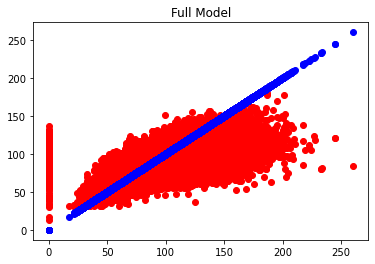

In [19]:
if max(y_test) >= max(y_pred):
    my_range = int(max(y_test))
else:
    my_range = int(max(y_pred))
my_range = int(max(y_test))
plt.scatter(y_test, y_pred, color='red')
plt.scatter(y_test, y_test, color='blue')
plt.title('Full Model')
plt.show()

In [20]:
errors = abs(y_pred - y_test)

rmse = mean_squared_error(y_pred, y_test, squared=False)
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Error:', round(np.mean(errors), 2), '.')
print(f'RMSE. {rmse}')

Accuracy: -inf %.
Mean Absolute Error: 12.06 .
RMSE. 16.89878757621936


#### Get most important features

In [21]:
feature_list = list(X_train.columns.values)

In [22]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)  if importance>= 0.01]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print("Variables with the biggest effect:")
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variables with the biggest effect:
Variable: Best3BenchKg         Importance: 0.58
Variable: Mean height          Importance: 0.17
Variable: Best3DeadliftKg      Importance: 0.06
Variable: Age                  Importance: 0.04
Variable: Best3SquatKg         Importance: 0.03
Variable: Equipment Single-ply Importance: 0.03
Variable: Competition_year     Importance: 0.02
Variable: TotalKg              Importance: 0.02


[None, None, None, None, None, None, None, None]

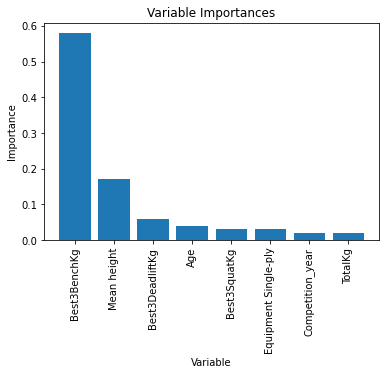

In [23]:
feature_names = []
y_values = []
for a,b in feature_importances:
    feature_names.append(a)
    y_values.append(b)
    
x_values = list(range(len(feature_names)))
plt.bar(x_values, y_values, orientation = 'vertical')
plt.xticks(x_values, feature_names, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.savefig('explainableAI/featureImportance_RawModel.png')
plt.show()

### Retrain model with only the important variables

In [24]:
# Only feed the new columns to the model

In [25]:
X_train_important = X_train[feature_names]
X_test_important = X_test[feature_names]
X_val_important = X_val[feature_names]

In [26]:
# Build a new regressor

In [27]:
n_estimators = 100
regressor_most_important = RandomForestRegressor(n_estimators = n_estimators, random_state = 0, max_depth = 10)

In [28]:
regressor_most_important.fit(X_train_important, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [29]:
y_pred_most_important = regressor_most_important.predict(X_test_important)

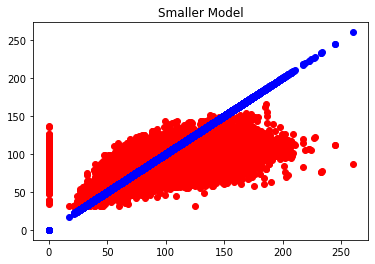

In [30]:
if max(y_test) >= max(y_pred_most_important):
    my_range = int(max(y_test))
else:
    my_range = int(max(y_pred_most_important))
my_range = int(max(y_test))
plt.scatter(y_test, y_pred_most_important, color='red')
plt.scatter(y_test, y_test, color='blue')
plt.title('Smaller Model')
plt.show()

In [31]:
errors = abs(y_pred_most_important - y_test)

rmse = mean_squared_error(y_pred_most_important, y_test, squared=False)
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Error:', round(np.mean(errors), 2), '.')
print(f'RMSE. {rmse}')

Accuracy: -inf %.
Mean Absolute Error: 12.22 .
RMSE. 17.118425062290388


In [32]:
# Get numerical feature importances
importances = list(regressor_most_important.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print("Variables with the biggest effect:")
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variables with the biggest effect:
Variable: Age                  Importance: 0.6
Variable: Valid_Results        Importance: 0.18
Variable: Competition_year     Importance: 0.07
Variable: Best3SquatKg         Importance: 0.05
Variable: Best3BenchKg         Importance: 0.03
Variable: Best3DeadliftKg      Importance: 0.03
Variable: TotalKg              Importance: 0.03
Variable: Mean height          Importance: 0.02


[None, None, None, None, None, None, None, None]

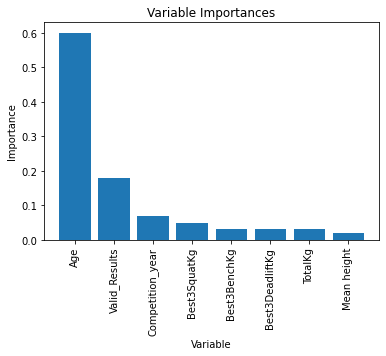

In [33]:
feature_names = []
y_values = []
for a,b in feature_importances:
    feature_names.append(a)
    y_values.append(b)
    
x_values = list(range(len(feature_names)))
plt.bar(x_values, y_values, orientation = 'vertical')
plt.xticks(x_values, feature_names, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.savefig('explainableAI/featureImportance_SmallerModel.png')
plt.show()

In [34]:
n_estimators = 100
for i in range(n_estimators):
    tree = regressor_most_important.estimators_[i]
    export_graphviz(tree
                    , out_file = 'explainableAI/tree_'+str(i)+'.dot'
                    , feature_names = feature_names
                    , rounded = True
                    , precision = 1)
    (graph, ) = pydot.graph_from_dot_file('explainableAI/tree_'+str(i)+'.dot')
    graph.write_png('explainableAI/tree_'+str(i)+'_2.png')
    print(f"Tree number {i} has been processed")

Tree number 0 has been processed
Tree number 1 has been processed
Tree number 2 has been processed
Tree number 3 has been processed
Tree number 4 has been processed
Tree number 5 has been processed
Tree number 6 has been processed
Tree number 7 has been processed
Tree number 8 has been processed
Tree number 9 has been processed
Tree number 10 has been processed
Tree number 11 has been processed
Tree number 12 has been processed
Tree number 13 has been processed
Tree number 14 has been processed
Tree number 15 has been processed
Tree number 16 has been processed
Tree number 17 has been processed
Tree number 18 has been processed
Tree number 19 has been processed
Tree number 20 has been processed
Tree number 21 has been processed
Tree number 22 has been processed
Tree number 23 has been processed
Tree number 24 has been processed
Tree number 25 has been processed
Tree number 26 has been processed
Tree number 27 has been processed
Tree number 28 has been processed
Tree number 29 has been 

### Predict on remaining dataset, and combine and return

In [35]:
y_pred_train = regressor_most_important.predict(X_train_important)
y_pred_test = regressor_most_important.predict(X_test_important)
y_pred_val = regressor_most_important.predict(X_val_important)

In [36]:
y_pred_train_DF = pd.DataFrame({"trueValue":y_train, 'predicted':y_pred_train})
y_pred_train_DF
resultsToReturn = df.join(y_pred_train_DF)
resultsToReturn.drop('trueValue', axis=1, inplace=True)
resultsToReturn

,Name,Continent,Country,Sex,Age,BodyweightKg,Valid_Results,Competition_year,Date,Event,Equipment,WeightClassKg,AgeClass,Division,Tested,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Wilks_Old,Wilks_2020,Mean height,Mean height lower 95% uncertainty interval,Mean height upper 95% uncertainty interval,Mean height standard error,State,Federation,ParentFederation,MeetCountry,MeetState,MeetTown,MeetName,predicted
0,Alona Vladi,Europe,Russia,F,33.0,58.30,True,2019,2019-05-11,SBD,Raw,60,24-34,O,Yes,75.0,80.0,-90.0,80.0,50.0,55.0,60.0,60.0,95.0,105.0,107.5,107.5,247.5,1,279.44,282.18,249.42,57.10,104.412659,104.412659,164.396953,163.619191,165.201879,0.403077,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament,NaN
1,Galina Solovyanova,Europe,Russia,F,43.0,73.10,True,2019,2019-05-11,SBD,Raw,75,40-44,M1,Yes,95.0,100.0,105.0,105.0,62.5,67.5,-72.5,67.5,100.0,110.0,-120.0,110.0,282.5,1,278.95,272.99,240.35,56.76,58.012415,58.012415,164.014897,163.492915,164.532035,0.267605,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament,62.848765
2,Daniil Voronin,Europe,Russia,M,15.5,67.40,True,2019,2019-05-11,SBD,Raw,75,16-17,T,Yes,85.0,90.0,100.0,100.0,55.0,62.5,-65.0,62.5,90.0,100.0,105.0,105.0,267.5,1,206.40,206.49,200.45,41.24,244.997025,244.997025,171.738549,169.903403,173.548792,0.924952,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament,60.740547
3,Aleksey Krasov,Europe,Russia,M,35.0,66.65,True,2019,2019-05-11,SBD,Raw,75,35-39,O,Yes,125.0,132.0,137.5,137.5,115.0,122.5,-127.5,122.5,150.0,165.0,170.0,170.0,430.0,1,334.49,334.94,325.32,66.68,396.936740,396.936740,176.819650,175.867796,177.757207,0.472990,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament,NaN
4,Margarita Pleschenkova,Europe,Russia,M,26.5,72.45,True,2019,2019-05-11,SBD,Raw,75,24-34,O,Yes,80.0,85.0,90.0,90.0,40.0,50.0,-60.0,50.0,112.5,120.0,125.0,125.0,265.0,1,194.46,193.55,187.29,39.34,231.063262,231.063262,176.191941,174.683642,177.673411,0.762665,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament,72.182318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153641,Inna Orobets,Europe,Ukraine,F,45.0,109.30,True,2016,2016-11-14,SBD,Single-ply,84+,45-49,Open,Yes,235.0,-242.5,242.5,242.5,175.0,182.5,187.5,187.5,200.0,210.0,215.0,215.0,645.0,3,532.83,525.14,447.12,93.16,30.615376,30.615376,165.530314,162.112004,168.840950,1.742301,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships,98.296133
1153642,Ágnes Szabó,Europe,Hungary,F,27.5,113.22,True,2016,2016-11-14,SBD,Single-ply,84+,24-34,Open,Yes,-237.5,237.5,-247.5,237.5,182.5,190.0,195.0,195.0,185.0,200.0,-210.0,200.0,632.5,4,516.46,511.26,434.61,90.57,26.225743,26.225743,162.006625,157.712146,167.634780,2.531992,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships,NaN
1153643,Brenda van der Meulen,Europe,Netherlands,F,37.5,110.79,True,2016,2016-11-14,SBD,Single-ply,84+,35-39,Open,Yes,210.0,222.5,227.5,227.5,190.0,-200.0,200.0,200.0,185.0,190.0,-195.0,190.0,617.5,5,507.79,501.32,426.60,88.89,27.828705,27.828705,169.686093,168.178874,171.215152,0.775269,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships,100.431081
1153644,Kelly Phasey,Europe,England,F,39.5,124.53,True,2016,2016-11-14,SBD,Single-ply,84+,35-39,Open,Yes,210.0,220.0,-227.5,220.0,140.0,-147.5,150.0,150.0,145.0,-155.0,-155.0,145.0,515.0,6,409.13,409.13,345.98,72.24,14.771645,14.771645,163.213673,162.833707,163.604237,0.199809,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships,89.474265


In [37]:
y_pred_train_DF = pd.DataFrame({"trueValue":y_train, 'predicted':y_pred_train})

In [38]:
y_pred_test_DF = pd.DataFrame({"trueValue":y_test, 'predicted':y_pred_test})

In [39]:
y_pred_val_DF = pd.DataFrame({"trueValue":y_val, 'predicted':y_pred_val})

In [40]:
predictions_concatenated = pd.concat([y_pred_train_DF, y_pred_test_DF, y_pred_val_DF])

In [41]:
resultsToReturn = df.join(predictions_concatenated)

## Cleanse dataset and return it

In [42]:
resultsToReturn.drop('WeightClassKg', axis=1, inplace=True)
resultsToReturn.drop('AgeClass', axis=1, inplace=True)
resultsToReturn.drop('Division', axis=1, inplace=True)
resultsToReturn.drop('Tested', axis=1, inplace=True)
resultsToReturn.drop('Place', axis=1, inplace=True)
resultsToReturn.drop('State', axis=1, inplace=True)
resultsToReturn.drop('Federation', axis=1, inplace=True)
resultsToReturn.drop('MeetCountry', axis=1, inplace=True)
resultsToReturn.drop('MeetState', axis=1, inplace=True)
resultsToReturn.drop('MeetTown', axis=1, inplace=True)
resultsToReturn.drop('MeetName', axis=1, inplace=True)
resultsToReturn.drop('Competition_year', axis=1, inplace=True)
resultsToReturn.drop('Squat1Kg', axis=1, inplace=True)
resultsToReturn.drop('Squat2Kg', axis=1, inplace=True)
resultsToReturn.drop('Squat3Kg', axis=1, inplace=True)
resultsToReturn.drop('Bench1Kg', axis=1, inplace=True)
resultsToReturn.drop('Bench2Kg', axis=1, inplace=True)
resultsToReturn.drop('Bench3Kg', axis=1, inplace=True)
resultsToReturn.drop('Deadlift1Kg', axis=1, inplace=True)
resultsToReturn.drop('Deadlift2Kg', axis=1, inplace=True)
resultsToReturn.drop('Deadlift3Kg', axis=1, inplace=True)
resultsToReturn.drop('Wilks_Old', axis=1, inplace=True)
resultsToReturn.drop('Wilks_2020', axis=1, inplace=True)
resultsToReturn.drop('Mean height lower 95% uncertainty interval', axis=1, inplace=True)
resultsToReturn.drop('Mean height upper 95% uncertainty interval', axis=1, inplace=True)
resultsToReturn.drop('Mean height standard error', axis=1, inplace=True)
resultsToReturn.drop('trueValue', axis=1, inplace=True)

In [43]:
resultsToReturn.to_csv('dataframe_to_visualize.csv')

In [44]:
resultsToReturn

,Name,Continent,Country,Sex,Age,BodyweightKg,Valid_Results,Date,Event,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,Mean height,ParentFederation,predicted
0,Alona Vladi,Europe,Russia,F,33.0,58.30,True,2019-05-11,SBD,Raw,80.0,60.0,107.5,247.5,279.44,282.18,249.42,57.10,164.396953,NaN,59.467789
1,Galina Solovyanova,Europe,Russia,F,43.0,73.10,True,2019-05-11,SBD,Raw,105.0,67.5,110.0,282.5,278.95,272.99,240.35,56.76,164.014897,NaN,62.848765
2,Daniil Voronin,Europe,Russia,M,15.5,67.40,True,2019-05-11,SBD,Raw,100.0,62.5,105.0,267.5,206.40,206.49,200.45,41.24,171.738549,NaN,60.740547
3,Aleksey Krasov,Europe,Russia,M,35.0,66.65,True,2019-05-11,SBD,Raw,137.5,122.5,170.0,430.0,334.49,334.94,325.32,66.68,176.819650,NaN,84.032452
4,Margarita Pleschenkova,Europe,Russia,M,26.5,72.45,True,2019-05-11,SBD,Raw,90.0,50.0,125.0,265.0,194.46,193.55,187.29,39.34,176.191941,NaN,72.182318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153641,Inna Orobets,Europe,Ukraine,F,45.0,109.30,True,2016-11-14,SBD,Single-ply,242.5,187.5,215.0,645.0,532.83,525.14,447.12,93.16,165.530314,IPF,98.296133
1153642,Ágnes Szabó,Europe,Hungary,F,27.5,113.22,True,2016-11-14,SBD,Single-ply,237.5,195.0,200.0,632.5,516.46,511.26,434.61,90.57,162.006625,IPF,94.991499
1153643,Brenda van der Meulen,Europe,Netherlands,F,37.5,110.79,True,2016-11-14,SBD,Single-ply,227.5,200.0,190.0,617.5,507.79,501.32,426.60,88.89,169.686093,IPF,100.431081
1153644,Kelly Phasey,Europe,England,F,39.5,124.53,True,2016-11-14,SBD,Single-ply,220.0,150.0,145.0,515.0,409.13,409.13,345.98,72.24,163.213673,IPF,89.474265


In [45]:
resultsToReturn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153646 entries, 0 to 1153645
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Name              1153646 non-null  object        
 1   Continent         1153646 non-null  object        
 2   Country           1153646 non-null  object        
 3   Sex               1153646 non-null  object        
 4   Age               1153646 non-null  float64       
 5   BodyweightKg      1147556 non-null  float64       
 6   Valid_Results     1153646 non-null  bool          
 7   Date              1153646 non-null  datetime64[ns]
 8   Event             1153646 non-null  object        
 9   Equipment         1153646 non-null  object        
 10  Best3SquatKg      669314 non-null   float64       
 11  Best3BenchKg      1004198 non-null  float64       
 12  Best3DeadliftKg   769231 non-null   float64       
 13  TotalKg           1088330 non-null  float6

## Test reading in

In [46]:
test_read = pd.read_csv('dataframe_to_visualize.csv', index_col=0, parse_dates=['Date'])

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [47]:
test_read

,Name,Continent,Country,Sex,Age,BodyweightKg,Valid_Results,Date,Event,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,Mean height,ParentFederation,predicted
0,Alona Vladi,Europe,Russia,F,33.0,58.30,True,2019-05-11,SBD,Raw,80.0,60.0,107.5,247.5,279.44,282.18,249.42,57.10,164.396953,NaN,59.467789
1,Galina Solovyanova,Europe,Russia,F,43.0,73.10,True,2019-05-11,SBD,Raw,105.0,67.5,110.0,282.5,278.95,272.99,240.35,56.76,164.014897,NaN,62.848765
2,Daniil Voronin,Europe,Russia,M,15.5,67.40,True,2019-05-11,SBD,Raw,100.0,62.5,105.0,267.5,206.40,206.49,200.45,41.24,171.738549,NaN,60.740547
3,Aleksey Krasov,Europe,Russia,M,35.0,66.65,True,2019-05-11,SBD,Raw,137.5,122.5,170.0,430.0,334.49,334.94,325.32,66.68,176.819650,NaN,84.032452
4,Margarita Pleschenkova,Europe,Russia,M,26.5,72.45,True,2019-05-11,SBD,Raw,90.0,50.0,125.0,265.0,194.46,193.55,187.29,39.34,176.191941,NaN,72.182318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153641,Inna Orobets,Europe,Ukraine,F,45.0,109.30,True,2016-11-14,SBD,Single-ply,242.5,187.5,215.0,645.0,532.83,525.14,447.12,93.16,165.530314,IPF,98.296133
1153642,Ágnes Szabó,Europe,Hungary,F,27.5,113.22,True,2016-11-14,SBD,Single-ply,237.5,195.0,200.0,632.5,516.46,511.26,434.61,90.57,162.006625,IPF,94.991499
1153643,Brenda van der Meulen,Europe,Netherlands,F,37.5,110.79,True,2016-11-14,SBD,Single-ply,227.5,200.0,190.0,617.5,507.79,501.32,426.60,88.89,169.686093,IPF,100.431081
1153644,Kelly Phasey,Europe,England,F,39.5,124.53,True,2016-11-14,SBD,Single-ply,220.0,150.0,145.0,515.0,409.13,409.13,345.98,72.24,163.213673,IPF,89.474265


In [48]:
test_read.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153646 entries, 0 to 1153645
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Name              1153646 non-null  object        
 1   Continent         1153646 non-null  object        
 2   Country           1153646 non-null  object        
 3   Sex               1153646 non-null  object        
 4   Age               1153646 non-null  float64       
 5   BodyweightKg      1147556 non-null  float64       
 6   Valid_Results     1153646 non-null  bool          
 7   Date              1153646 non-null  datetime64[ns]
 8   Event             1153646 non-null  object        
 9   Equipment         1153646 non-null  object        
 10  Best3SquatKg      669314 non-null   float64       
 11  Best3BenchKg      1004198 non-null  float64       
 12  Best3DeadliftKg   769231 non-null   float64       
 13  TotalKg           1088330 non-null  float6